In [5]:
import csv
import pandas as pd
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time


service = Service(r"C:\Windows\chromedriver.exe")
driver = webdriver.Chrome(service=service)

url = 'https://www.espncricinfo.com/records/list-of-match-results-by-year-307852'
driver.get(url)
time.sleep(5)

match_data = []
team_results = {}

def remove_overlay():
    try:
        overlay = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "wzrk-overlay"))
        )
        driver.execute_script("arguments[0].remove();", overlay)
        print("Overlay removed successfully.")
    except Exception:
        pass  

soup = BeautifulSoup(driver.page_source, 'html.parser')
year_links = soup.find_all('a', href=True, text=True)

for link in year_links:
    if link.text.isdigit() and int(link.text) >= 2013:
        year = link.text
        print(f"Processing year: {year}")

        remove_overlay()

        year_link = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.LINK_TEXT, year))
        )
        driver.execute_script("arguments[0].click();", year_link)

        time.sleep(5)

        year_page_source = driver.page_source
        year_soup = BeautifulSoup(year_page_source, 'html.parser')

        match_table = year_soup.find('table', class_='ds-w-full ds-table ds-table-xs ds-table-auto ds-w-full ds-overflow-scroll ds-scrollbar-hide')

        if match_table:
            rows = match_table.find_all('tr')[1:]  
            for row in rows:
                columns = row.find_all('td')
                if len(columns) >= 5:  
                    team_1 = columns[0].get_text(strip=True)
                    team_2 = columns[1].get_text(strip=True)
                    winner = columns[2].get_text(strip=True)
                    margin = columns[3].get_text(strip=True)
                    ground = columns[4].get_text(strip=True)
                    column6 = columns[6].get_text(strip=True)
                    MatchID = column6.split('#')[1].strip()


                    match_data.append({
                        "Year": year,
                        "Team 1": team_1,
                        "Team 2": team_2,
                        "Winner": winner,
                        "Margin": margin,
                        "Ground": ground,
                        "MatchID": MatchID
                    })

                    
                    scorecard_link = f"https://www.espncricinfo.com{columns[6].find('a')['href']}"
                    driver.get(scorecard_link)
                    time.sleep(5)

                   
                    try:
                        
                        score_1_element = driver.find_element(By.XPATH, '//*[@id="main-container"]/div[5]/div/div/div[3]/div[1]/div[1]/div/div[1]/div[2]/div[1]/div/div/div[2]/div/div[1]/div[2]/strong')
                        score_2_element = driver.find_element(By.XPATH, '//*[@id="main-container"]/div[5]/div/div/div[3]/div[1]/div[1]/div/div[1]/div[2]/div[1]/div/div/div[2]/div/div[2]/div[2]/strong')
                        
        
                        team_1_score = score_1_element.text.strip() if score_1_element else "Not Found"
                        team_2_score = score_2_element.text.strip() if score_2_element else "Not Found"
                        
                        print(f"Year: {year} | Team 1: {team_1} | Team 2: {team_2} | Winner: {winner} | Margin: {margin} | Ground: {ground} | MatchID: {MatchID}")
                        print(f"Team 1 Score: {team_1_score}")
                        print(f"Team 2 Score: {team_2_score}")

                        match_data[-1]["Team 1 Score"] = team_1_score
                        match_data[-1]["Team 2 Score"] = team_2_score
                    except Exception as e:
                        print(f"Error extracting score for MatchID {MatchID}: {e}")
                        match_data[-1]["Team 1 Score"] = "Error"
                        match_data[-1]["Team 2 Score"] = "Error"

                    for team in [team_1, team_2]:
                        if team not in team_results:
                            team_results[team] = []
                        team_results[team].append("Win" if team == winner else "Loss")
                        if len(team_results[team]) > 10:  
                            team_results[team].pop(0)

                    driver.back()  
                    time.sleep(3)

        else:
            print(f"Table not found for the year {year}")

        driver.back()
        time.sleep(3)

driver.quit()

match_data_df = pd.DataFrame(match_data)
team_results_df = pd.DataFrame(
    [{"Team Name": team, "Last 10 Match Results": ", ".join(results)} for team, results in team_results.items()]
)

output_file = "cricket_match_results_with_scores.xlsx"
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    match_data_df.to_excel(writer, sheet_name="Match Results", index=False)
    team_results_df.to_excel(writer, sheet_name="Team Results", index=False)

print(f"Data saved to {output_file}.")

C:\Users\vivek\AppData\Local\Temp\ipykernel_22748\4219925410.py:33: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  year_links = soup.find_all('a', href=True, text=True)


Processing year: 2013
Overlay removed successfully.
Year: 2013 | Team 1: Pakistan | Team 2: Sri Lanka | Winner: Sri Lanka | Margin: 24 runs | Ground: Dubai (DICS) | MatchID: 351
Team 1 Score: 211/3
Team 2 Score: 187
Year: 2013 | Team 1: Pakistan | Team 2: Sri Lanka | Winner: Pakistan | Margin: 3 wickets | Ground: Dubai (DICS) | MatchID: 350
Team 1 Score: 145/5
Team 2 Score: 146/7
Year: 2013 | Team 1: Afghanistan | Team 2: Pakistan | Winner: Pakistan | Margin: 6 wickets | Ground: Sharjah | MatchID: 349
Team 1 Score: 137/8
Team 2 Score: 138/4
Year: 2013 | Team 1: Afghanistan | Team 2: Ireland | Winner: Ireland | Margin: 68 runs | Ground: Abu Dhabi | MatchID: 348
Team 1 Score: 225/7
Team 2 Score: 157
Year: 2013 | Team 1: Netherlands | Team 2: Scotland | Winner: Netherlands | Margin: 8 wickets | Ground: Abu Dhabi | MatchID: 347
Team 1 Score: 147/6
Team 2 Score: 149/2
Year: 2013 | Team 1: Canada | Team 2: Kenya | Winner: Kenya | Margin: 21 runs | Ground: Sharjah | MatchID: 346
Team 1 Score:

In [1]:
import pandas as pd
file_path = "cricket_match_results_with_scores.xlsx" 
df = pd.read_excel(file_path)

teams_to_keep = [
    "Afghanistan", "Australia", "Bangladesh", "England", "India", 
    "Ireland", "New Zealand", "Pakistan", "South Africa", "Sri Lanka",
    "West Indies", "Zimbabwe", "Namibia", "Nepal", "Netherlands",
    "Oman", "Papua New Guinea", "Scotland", "United Arab Emirates",
    "United States of America"
]

df_filtered = df[
    (df['Team 1'].isin(teams_to_keep)) & (df['Team 2'].isin(teams_to_keep))
]

filtered_file_path = "filtered_match_results.xlsx"
df_filtered.to_excel(filtered_file_path, index=False)

In [2]:
file_path = "filtered_match_results.xlsx"  
df = pd.read_excel(file_path)
def process_score(score):
    try:
        if '/' in score:
            runs, wickets = map(float, score.split('/'))  
            return int(runs), int(wickets)  
        else:
            runs = float(score)  
            return int(runs), 10
    except:
        return 0, 0

df['Team 1 Runs'], df['Team 1 Wickets'] = zip(*df['Team 1 Score'].apply(process_score))
df['Team 2 Runs'], df['Team 2 Wickets'] = zip(*df['Team 2 Score'].apply(process_score))

In [5]:
df

,Year,Team 1,Team 2,Winner,Margin,Ground,MatchID,Team 1 Score,Team 2 Score,Team 1 Runs,Team 1 Wickets,Team 2 Runs,Team 2 Wickets
0,2013,Pakistan,Sri Lanka,Sri Lanka,24 runs,Dubai (DICS),351,211/3,187,211,3,187,10
1,2013,Pakistan,Sri Lanka,Pakistan,3 wickets,Dubai (DICS),350,145/5,146/7,145,5,146,7
2,2013,Afghanistan,Pakistan,Pakistan,6 wickets,Sharjah,349,137/8,138/4,137,8,138,4
3,2013,Afghanistan,Ireland,Ireland,68 runs,Abu Dhabi,348,225/7,157,225,7,157,10
4,2013,Netherlands,Scotland,Netherlands,8 wickets,Abu Dhabi,347,147/6,149/2,147,6,149,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,2023,Zimbabwe,Ireland,Ireland,6 wickets,Harare,1988,144,150/4,144,10,150,4
843,2023,Zimbabwe,Ireland,Zimbabwe,5 wickets,Harare,1987,114,118/5,114,10,118,5
844,2023,India,Sri Lanka,India,91 runs,Rajkot,1986,228/5,137,228,5,137,10
845,2023,India,Sri Lanka,Sri Lanka,16 runs,Pune,1985,206/6,190/8,206,6,190,8


In [7]:
def determine_winner(row):
    if row['Winner'] == row['Team 1']:
        return "Team 1"
    elif row['Winner'] == row['Team 2']:
        return "Team 2"
    else:
        return "Draw"

df['Team_Winner'] = df.apply(determine_winner, axis=1)

In [9]:
df


,Year,Team 1,Team 2,Winner,Margin,Ground,MatchID,Team 1 Score,Team 2 Score,Team 1 Runs,Team 1 Wickets,Team 2 Runs,Team 2 Wickets,Team_Winner
0,2013,Pakistan,Sri Lanka,Sri Lanka,24 runs,Dubai (DICS),351,211/3,187,211,3,187,10,Team 2
1,2013,Pakistan,Sri Lanka,Pakistan,3 wickets,Dubai (DICS),350,145/5,146/7,145,5,146,7,Team 1
2,2013,Afghanistan,Pakistan,Pakistan,6 wickets,Sharjah,349,137/8,138/4,137,8,138,4,Team 2
3,2013,Afghanistan,Ireland,Ireland,68 runs,Abu Dhabi,348,225/7,157,225,7,157,10,Team 2
4,2013,Netherlands,Scotland,Netherlands,8 wickets,Abu Dhabi,347,147/6,149/2,147,6,149,2,Team 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,2023,Zimbabwe,Ireland,Ireland,6 wickets,Harare,1988,144,150/4,144,10,150,4,Team 2
843,2023,Zimbabwe,Ireland,Zimbabwe,5 wickets,Harare,1987,114,118/5,114,10,118,5,Team 1
844,2023,India,Sri Lanka,India,91 runs,Rajkot,1986,228/5,137,228,5,137,10,Team 1
845,2023,India,Sri Lanka,Sri Lanka,16 runs,Pune,1985,206/6,190/8,206,6,190,8,Team 2


In [11]:
def determine_won_by(margin):
    if isinstance(margin, str):
        if 'runs' in margin.lower():
            return "Runs"
        elif 'wickets' in margin.lower():
            return "Wickets"
    return "Unknown"

df['Won_By'] = df['Margin'].apply(determine_won_by)
df

,Year,Team 1,Team 2,Winner,Margin,Ground,MatchID,Team 1 Score,Team 2 Score,Team 1 Runs,Team 1 Wickets,Team 2 Runs,Team 2 Wickets,Team_Winner,Won_By
0,2013,Pakistan,Sri Lanka,Sri Lanka,24 runs,Dubai (DICS),351,211/3,187,211,3,187,10,Team 2,Runs
1,2013,Pakistan,Sri Lanka,Pakistan,3 wickets,Dubai (DICS),350,145/5,146/7,145,5,146,7,Team 1,Wickets
2,2013,Afghanistan,Pakistan,Pakistan,6 wickets,Sharjah,349,137/8,138/4,137,8,138,4,Team 2,Wickets
3,2013,Afghanistan,Ireland,Ireland,68 runs,Abu Dhabi,348,225/7,157,225,7,157,10,Team 2,Runs
4,2013,Netherlands,Scotland,Netherlands,8 wickets,Abu Dhabi,347,147/6,149/2,147,6,149,2,Team 1,Wickets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,2023,Zimbabwe,Ireland,Ireland,6 wickets,Harare,1988,144,150/4,144,10,150,4,Team 2,Wickets
843,2023,Zimbabwe,Ireland,Zimbabwe,5 wickets,Harare,1987,114,118/5,114,10,118,5,Team 1,Wickets
844,2023,India,Sri Lanka,India,91 runs,Rajkot,1986,228/5,137,228,5,137,10,Team 1,Runs
845,2023,India,Sri Lanka,Sri Lanka,16 runs,Pune,1985,206/6,190/8,206,6,190,8,Team 2,Runs


In [13]:
def swap_scores(row):
    if row['Team_Winner'] == "Team 2" and row['Won_By'] == "Runs":
        return row['Team 2 Score'], row['Team 1 Score']
    
    elif row['Team_Winner'] == "Team 1" and row['Won_By'] == "Wickets":
        return row['Team 2 Score'], row['Team 1 Score']
    
    return row['Team 1 Score'], row['Team 2 Score']

df['Team 1 Score'], df['Team 2 Score'] = zip(*df.apply(swap_scores, axis=1))
df

,Year,Team 1,Team 2,Winner,Margin,Ground,MatchID,Team 1 Score,Team 2 Score,Team 1 Runs,Team 1 Wickets,Team 2 Runs,Team 2 Wickets,Team_Winner,Won_By
0,2013,Pakistan,Sri Lanka,Sri Lanka,24 runs,Dubai (DICS),351,187,211/3,211,3,187,10,Team 2,Runs
1,2013,Pakistan,Sri Lanka,Pakistan,3 wickets,Dubai (DICS),350,146/7,145/5,145,5,146,7,Team 1,Wickets
2,2013,Afghanistan,Pakistan,Pakistan,6 wickets,Sharjah,349,137/8,138/4,137,8,138,4,Team 2,Wickets
3,2013,Afghanistan,Ireland,Ireland,68 runs,Abu Dhabi,348,157,225/7,225,7,157,10,Team 2,Runs
4,2013,Netherlands,Scotland,Netherlands,8 wickets,Abu Dhabi,347,149/2,147/6,147,6,149,2,Team 1,Wickets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,2023,Zimbabwe,Ireland,Ireland,6 wickets,Harare,1988,144,150/4,144,10,150,4,Team 2,Wickets
843,2023,Zimbabwe,Ireland,Zimbabwe,5 wickets,Harare,1987,118/5,114,114,10,118,5,Team 1,Wickets
844,2023,India,Sri Lanka,India,91 runs,Rajkot,1986,228/5,137,228,5,137,10,Team 1,Runs
845,2023,India,Sri Lanka,Sri Lanka,16 runs,Pune,1985,190/8,206/6,206,6,190,8,Team 2,Runs


In [15]:
df['Team 1 Runs'], df['Team 1 Wickets'] = zip(*df['Team 1 Score'].apply(process_score))
df['Team 2 Runs'], df['Team 2 Wickets'] = zip(*df['Team 2 Score'].apply(process_score))

In [17]:
df

,Year,Team 1,Team 2,Winner,Margin,Ground,MatchID,Team 1 Score,Team 2 Score,Team 1 Runs,Team 1 Wickets,Team 2 Runs,Team 2 Wickets,Team_Winner,Won_By
0,2013,Pakistan,Sri Lanka,Sri Lanka,24 runs,Dubai (DICS),351,187,211/3,187,10,211,3,Team 2,Runs
1,2013,Pakistan,Sri Lanka,Pakistan,3 wickets,Dubai (DICS),350,146/7,145/5,146,7,145,5,Team 1,Wickets
2,2013,Afghanistan,Pakistan,Pakistan,6 wickets,Sharjah,349,137/8,138/4,137,8,138,4,Team 2,Wickets
3,2013,Afghanistan,Ireland,Ireland,68 runs,Abu Dhabi,348,157,225/7,157,10,225,7,Team 2,Runs
4,2013,Netherlands,Scotland,Netherlands,8 wickets,Abu Dhabi,347,149/2,147/6,149,2,147,6,Team 1,Wickets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,2023,Zimbabwe,Ireland,Ireland,6 wickets,Harare,1988,144,150/4,144,10,150,4,Team 2,Wickets
843,2023,Zimbabwe,Ireland,Zimbabwe,5 wickets,Harare,1987,118/5,114,118,5,114,10,Team 1,Wickets
844,2023,India,Sri Lanka,India,91 runs,Rajkot,1986,228/5,137,228,5,137,10,Team 1,Runs
845,2023,India,Sri Lanka,Sri Lanka,16 runs,Pune,1985,190/8,206/6,190,8,206,6,Team 2,Runs


In [19]:
df = df.drop_duplicates()

print("Missing values per column:")
print(df.isnull().sum())

df = df.fillna("Unknown")  
df = df.dropna()           

columns_to_drop = ['Margin', 'MatchID']  
df = df.drop(columns=columns_to_drop, axis=1)

print(df.info())


Missing values per column:
Year              0
Team 1            0
Team 2            0
Winner            0
Margin            0
Ground            0
MatchID           0
Team 1 Score      0
Team 2 Score      0
Team 1 Runs       0
Team 1 Wickets    0
Team 2 Runs       0
Team 2 Wickets    0
Team_Winner       0
Won_By            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Year            847 non-null    int64 
 1   Team 1          847 non-null    object
 2   Team 2          847 non-null    object
 3   Winner          847 non-null    object
 4   Ground          847 non-null    object
 5   Team 1 Score    847 non-null    object
 6   Team 2 Score    847 non-null    object
 7   Team 1 Runs     847 non-null    int64 
 8   Team 1 Wickets  847 non-null    int64 
 9   Team 2 Runs     847 non-null    int64 
 10  Team 2 Wickets  847 no

In [39]:
df['Home_Team_Won'] = (df['Team_Winner'] == df['Team 1']).astype(int)
df['Away_Team_Won'] = (df['Team_Winner'] == df['Team 2']).astype(int)

df['Home_Team_Won'] = df['Team_1_Won']
df['Away_Team_Won'] = df['Team_2_Won']

In [41]:
df

,Year,Team 1,Team 2,Ground,Team 1 Score,Team 2 Score,Team 1 Runs,Team 1 Wickets,Team 2 Runs,Team 2 Wickets,Team_Winner,Won_By,Team_1_Won,Team_2_Won,Home_Team_Won,Away_Team_Won
0,2013,Pakistan,Sri Lanka,Dubai (DICS),187,211/3,187,10,211,3,Team 2,Runs,0,1,0,1
1,2013,Pakistan,Sri Lanka,Dubai (DICS),146/7,145/5,146,7,145,5,Team 1,Wickets,1,0,1,0
2,2013,Afghanistan,Pakistan,Sharjah,137/8,138/4,137,8,138,4,Team 2,Wickets,0,1,0,1
3,2013,Afghanistan,Ireland,Abu Dhabi,157,225/7,157,10,225,7,Team 2,Runs,0,1,0,1
4,2013,Netherlands,Scotland,Abu Dhabi,149/2,147/6,149,2,147,6,Team 1,Wickets,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,2023,Zimbabwe,Ireland,Harare,144,150/4,144,10,150,4,Team 2,Wickets,0,1,0,1
843,2023,Zimbabwe,Ireland,Harare,118/5,114,118,5,114,10,Team 1,Wickets,1,0,1,0
844,2023,India,Sri Lanka,Rajkot,228/5,137,228,5,137,10,Team 1,Runs,1,0,1,0
845,2023,India,Sri Lanka,Pune,190/8,206/6,190,8,206,6,Team 2,Runs,0,1,0,1


In [15]:
df = pd.get_dummies(df, columns=['Team 1', 'Team 2', 'Ground'], drop_first=True)

print(df.head())


   Year Team 1 Score Team 2 Score  Team 1 Runs  Team 1 Wickets  Team 2 Runs  \
0  2013          187        211/3          187              10          211   
1  2013        146/7        145/5          146               7          145   
2  2013        137/8        138/4          137               8          138   
3  2013          157        225/7          157              10          225   
4  2013        149/2        147/6          149               2          147   

   Team 2 Wickets Team_Winner   Won_By  Team_1_Won  ...  Ground_Tarouba  \
0               3      Team 2     Runs           0  ...               0   
1               5      Team 1  Wickets           1  ...               0   
2               4      Team 2  Wickets           0  ...               0   
3               7      Team 2     Runs           0  ...               0   
4               6      Team 1  Wickets           1  ...               0   

   Ground_Taunton  Ground_The Hague  Ground_The Oval  \
0               0 

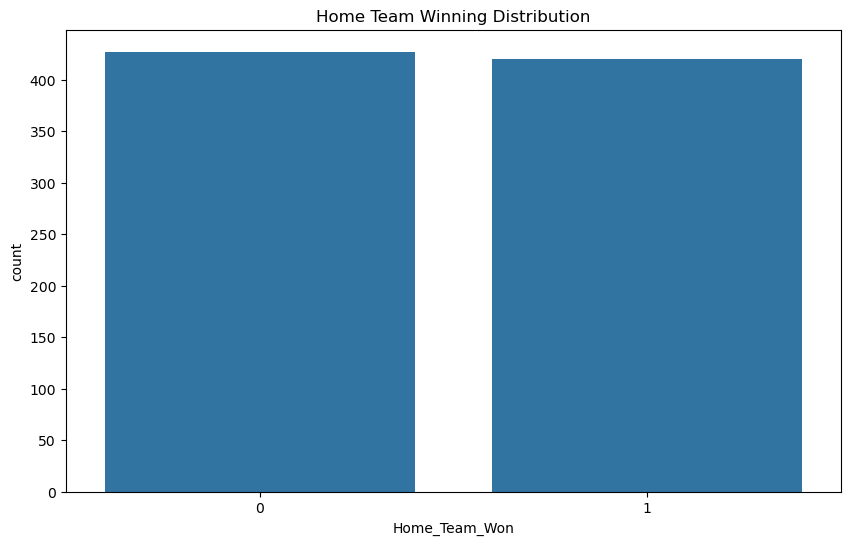

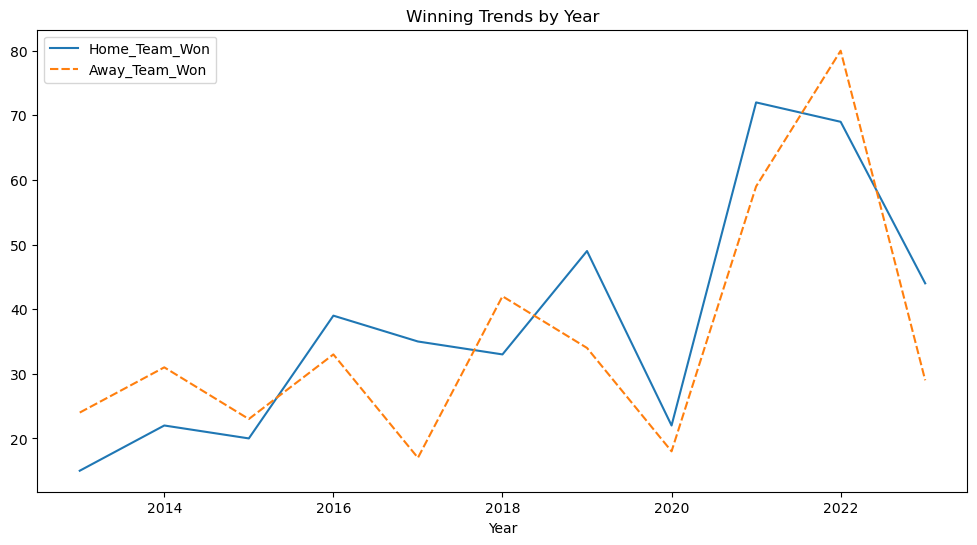

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

team_1_counts = df['Home_Team_Won'].value_counts()
team_2_counts = df['Away_Team_Won'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(x='Home_Team_Won', data=df)
plt.title('Home Team Winning Distribution')
plt.show()

winning_trends = df.groupby('Year')[['Home_Team_Won', 'Away_Team_Won']].sum()
plt.figure(figsize=(12, 6))
sns.lineplot(data=winning_trends)
plt.title('Winning Trends by Year')
plt.show()


In [53]:
df['Winner_Team_HA'] = df['Team_Winner'].apply(lambda x: 'Home' if x == 'Team 1' else 'Away')
df.drop(columns=['winner_team_HA'], inplace=True)
df

,Year,Team 1,Team 2,Ground,Team 1 Score,Team 2 Score,Team 1 Runs,Team 1 Wickets,Team 2 Runs,Team 2 Wickets,Team_Winner,Won_By,Team_1_Won,Team_2_Won,Home_Team_Won,Away_Team_Won,Winner_Team_HA
0,2013,Pakistan,Sri Lanka,Dubai (DICS),187,211/3,187,10,211,3,Team 2,Runs,0,1,0,1,Away
1,2013,Pakistan,Sri Lanka,Dubai (DICS),146/7,145/5,146,7,145,5,Team 1,Wickets,1,0,1,0,Home
2,2013,Afghanistan,Pakistan,Sharjah,137/8,138/4,137,8,138,4,Team 2,Wickets,0,1,0,1,Away
3,2013,Afghanistan,Ireland,Abu Dhabi,157,225/7,157,10,225,7,Team 2,Runs,0,1,0,1,Away
4,2013,Netherlands,Scotland,Abu Dhabi,149/2,147/6,149,2,147,6,Team 1,Wickets,1,0,1,0,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,2023,Zimbabwe,Ireland,Harare,144,150/4,144,10,150,4,Team 2,Wickets,0,1,0,1,Away
843,2023,Zimbabwe,Ireland,Harare,118/5,114,118,5,114,10,Team 1,Wickets,1,0,1,0,Home
844,2023,India,Sri Lanka,Rajkot,228/5,137,228,5,137,10,Team 1,Runs,1,0,1,0,Home
845,2023,India,Sri Lanka,Pune,190/8,206/6,190,8,206,6,Team 2,Runs,0,1,0,1,Away


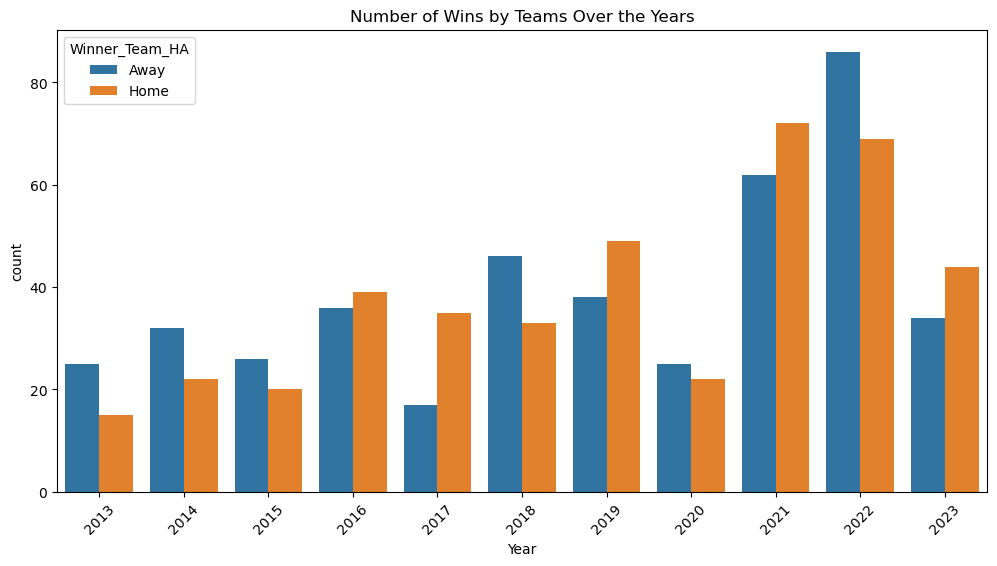

In [55]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Winner_Team_HA', data=df)
plt.title('Number of Wins by Teams Over the Years')
plt.xticks(rotation=45)
plt.show()


C:\Users\vivek\AppData\Local\Temp\ipykernel_96768\1828581061.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=team_wins.index, y=team_wins.values, palette='viridis')


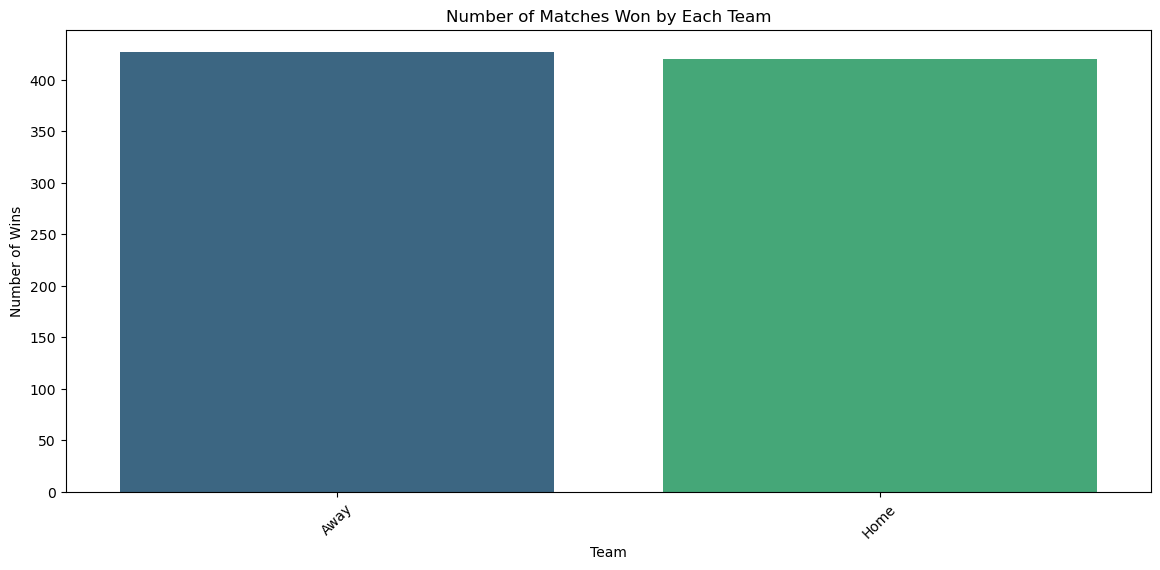

In [57]:
team_wins = df['Winner_Team_HA'].value_counts()

plt.figure(figsize=(14, 6))
sns.barplot(x=team_wins.index, y=team_wins.values, palette='viridis')
plt.title('Number of Matches Won by Each Team')
plt.xticks(rotation=45)
plt.xlabel('Team')
plt.ylabel('Number of Wins')
plt.show()


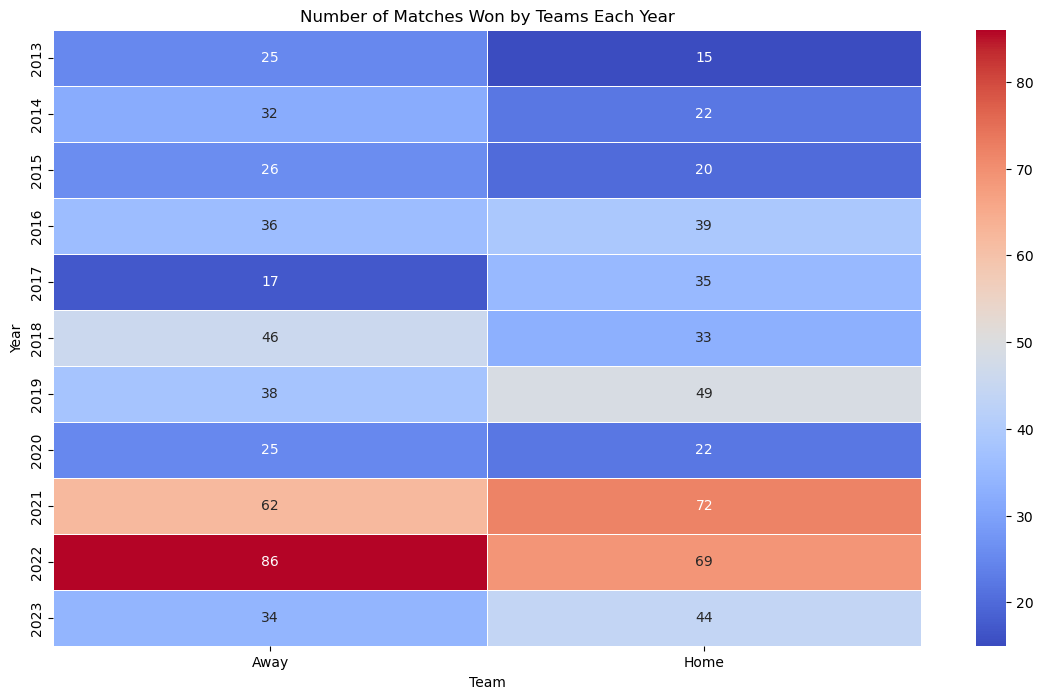

In [59]:

yearly_wins = df.groupby(['Year', 'Winner_Team_HA']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(yearly_wins, cmap='coolwarm', annot=True, fmt='d', linewidths=.5)
plt.title('Number of Matches Won by Teams Each Year')
plt.xlabel('Team')
plt.ylabel('Year')
plt.show()


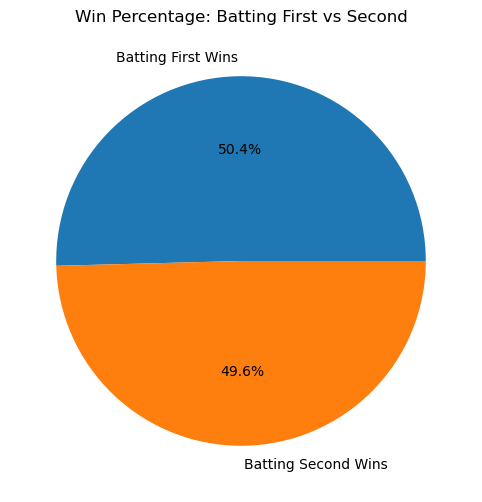

In [61]:

df['Batting_First'] = (df['Team_1_Won'] == 1).astype(int)

batting_stats = df['Batting_First'].value_counts(normalize=True) * 100

labels = ['Batting First Wins', 'Batting Second Wins']
plt.figure(figsize=(8, 6))
plt.pie(batting_stats, labels=labels, autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'])
plt.title('Win Percentage: Batting First vs Second')
plt.show()
